# Ensembles and XGBoost


In [ ]:
## Load and prepare data

In [ ]:
# ADDED THESES IMORT COMMANDS SO THAT WE CAN START WHERE WE LEFT OFF LAST TIME
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
# change some plotting settings
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg') 

# load data
iris = load_iris()
# X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target, test_size=0.30, random_state=0)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Random Forest Model

### Example Tree
<img src="iris_tree.png" alt="iris_tree" style="width: 400px;"/>
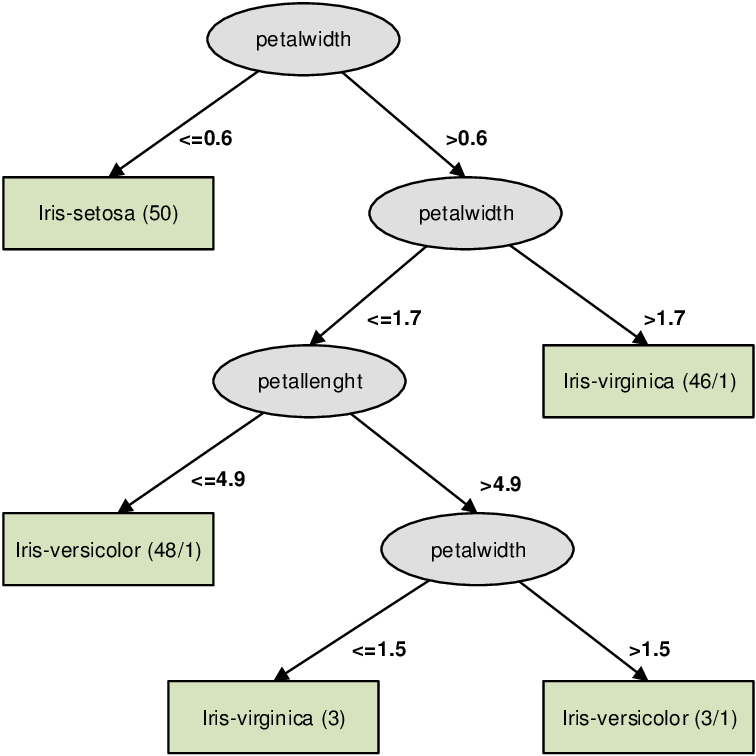

### With 100 Trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target, test_size=0.30, random_state=0)

In [ ]:
from sklearn.metrics import accuracy_score

# fitting training data
classifier.fit(X_train, Y_train)

# predicting test data based on 
y_pred = classifier.predict(X_test)

# take a look at accuracy
n_obs = len(Y_test)
accuracy = accuracy_score(Y_test,y_pred)
print(f'The test data contains {n_obs} observations, of which {int(accuracy * n_obs)} were classified correctly.')
print(f'Accuracy is: {accuracy:.3f}')

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classifier, X_test, Y_test)

### With 500 Trees (for comparison)

In [ ]:
# get new instance of RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
classifier.fit(X_train, Y_train)

y_pred = classifier.predict(X_test)

# take a look at accuracy
n_obs = len(Y_test)
accuracy = accuracy_score(Y_test,y_pred)
print(f'The test data contains {n_obs} observations, of which {int(accuracy * n_obs)} were classified correctly.')
print(f'Accuracy is: {accuracy:.3f}')

## Feature Importance
### ... for Iris Data

In [ ]:
classifier.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], classifier.feature_importances_):
    print(name, score)

### ... for a dataset with an ambundance of features
Dataset: https://www.openml.org/d/554

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(mnist["data"], mnist["target"])

In [ ]:
# ask students what this means
mnist["data"].shape, mnist["target"][:10]

In [ ]:
# define plotting function later
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation='nearest')
    plt.axis("off")

In [ ]:
plot_digit(classifier.feature_importances_)
cbar = plt.colorbar(ticks=[classifier.feature_importances_.min(), classifier.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

## Gradient Boosting with xgboost

In [ ]:
# if you had problems here, try installing with anaconda via 'conda install -c conda-forge xgboost'
!pip install xgboost


In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.DESCR)
# print(boston)
# print(type(boston))

In [ ]:
bdata = pd.DataFrame(boston.data, columns=boston['feature_names'])
X, y = bdata.iloc[:,:],boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
# print(y)
# print(X)

In [ ]:
import xgboost as xgb

### Main Hyperparameters:

* learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
* max_depth: determines how deeply each tree is allowed to grow during any boosting round.
* subsample: percentage of samples used per tree. Low value can lead to underfitting.
* colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
* n_estimators: number of trees you want to build.
* objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.

### Regularization Parameters:

* gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
* alpha: L1 regularization on leaf weights. A large value leads to more regularization.
* lambda: L2 regularization on leaf weights and is smoother than L1 regularization.


In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 10, 
                          n_estimators = 10)

In [ ]:
xg_reg.fit(X_train,y_train)
pred = xg_reg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE: %f" % (rmse))

In [ ]:
# back to classification (showing xgboost for classification, not only for regression)
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.30, random_state=0)

In [ ]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(random_state=42)
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
print(len(X_test))
print(accuracy_score(y_test,y_pred))

## k-Fold Cross Validation

In [ ]:
from xgboost import DMatrix
data_dmatrix = DMatrix(data=X,label=y)

* num_boost_round: denotes the number of trees you build (analogous to n_estimators)
* metrics: tells the evaluation metrics to be watched during CV
* as_pandas: to return the results in a pandas DataFrame.
* early_stopping_rounds: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.
* seed: for reproducibility of results.

In [ ]:
params = {"objective":"reg:linear",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 5, 
          'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, 
                    params=params, 
                    nfold=3,
                    num_boost_round=50,
                    early_stopping_rounds=10,
                    metrics="rmse", 
                    as_pandas=True, 
                    seed=123)

In [ ]:
cv_results.head()

## Visualize the Trees

In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [ ]:
!pip install graphviz
# if you have problems, try installing with anaconda "conda install -c anaconda graphviz "

In [ ]:
import matplotlib.pyplot as plt
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()